#### catatan: 
beberapa data taksonomi memang kosong dari NCBInya, misal data interaksi virus pycv malah terhubung ke genus capsicum bukan spesies capsicum. dan itu memang dari data GloBInya langsung

In [82]:
from tqdm import tqdm
from owlready2 import *
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG, Vertex
from pyrdf2vec.embedders import FastText,Word2Vec
from pyrdf2vec.walkers import RandomWalker
from pyvis.network import Network
from sklearn.manifold import TSNE
from umap import UMAP
from SPARQLWrapper import SPARQLWrapper
from jcopml.plot import plot_missing_value

import plotly.express as px
import pandas as pd
import numpy as np
import requests
import os
import networkx as nx
import matplotlib.pyplot as plt

from standardization import getTaxonomy
from vectorReferenced import get_taxon_vector
from process import cek_bfs, nx_to_pyviz

#### Parameter

In [83]:
acuan_='Bemisia' # vektor acuan
data_='2cri' #data virus
bobot_ed=1;
bobot_dc=1;

In [84]:
# link obo ncbi
ncbi_link = os.getcwd()+'/../data/ncbitaxon.owl'

#### input data

In [85]:
#1
#baca data
df_node=pd.read_csv('dari_praproses/'+data_+'_node.csv',index_col=0) 
df_edge=pd.read_csv('dari_praproses/'+data_+'_edge.csv',index_col=0)

In [86]:
#2
#isi data koson
takson=[
    'superkingdom','kingdom','phylum','class','order','family','genus','species'
]

for x,i in enumerate(takson):
    if (i!='superkingdom'): #selain superkingdom update dengan data sebelumnya
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x-1]]+'^'+i
    else: 
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x+1]]+'^'+i

#### Pengelompokan

In [87]:
# Binning of the data based on serangga, virus, tanaman, nogroup
filter_tanaman = df_node['kingdom']=='NCBI:33090_Viridiplantae' 
filter_virus = (
    (df_node['superkingdom']=='NCBI:10239_Viruses')
    | (df_node.taxon_name.str.contains(r'\b(virus\w*|\w*virus)\b',case=False))
    | (df_node.taxon_path.str.contains(r'\b(virus\w*|\w*virus)\b', case=False)) 
    #jika berawalan atau berakhiran kata virus
)
filter_serangga = ((df_node['class']=='NCBI:50557_Insecta') & (df_node['order']!='NCBI:7399_Hymenoptera')) #dan bukan lebah hymenoptera
# df_node['kingdom']=='NCBI:33208_Metazoa' and (df_node['phylum']=='NCBI:6656_Arthropoda' and 
#ini jadi dilema, ada kalau ingin memasukan artropoda lain misal, laba2 maka pake or. untuk saat ini fokus ke insect

df_node.loc[filter_tanaman, ['group','color']] = ["tanaman",'#1f922b'] #hijau
df_node.loc[filter_virus, ['group','color']] = ['virus','#671f92'] #ungu
df_node.loc[filter_serangga, ['group','color']] = ['serangga','#b22222'] #merah
df_node.loc[(
    (filter_tanaman==False) & 
    (filter_virus==False) &
    (filter_serangga==False) 
    ),['group','color']] = ['nogroup','#EADDCA'] #abu-abu

/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_46372/988445731.py:5: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_46372/988445731.py:6: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



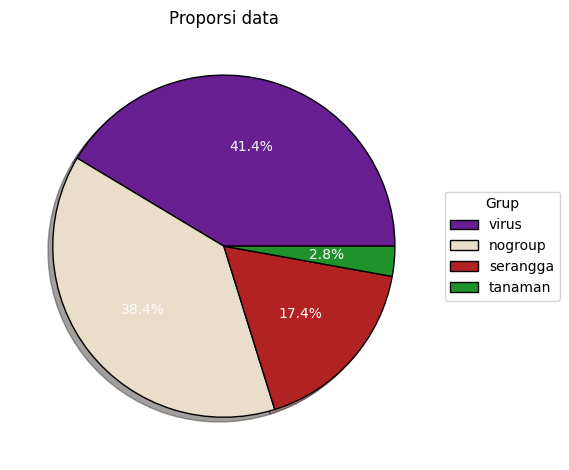

In [88]:
data = df_node.groupby(['group','color']).agg({'group': ['count'], }).reset_index().sort_values(
    ('group', 'count'),ascending=False
).reset_index(drop=True).values
labels = [i[0] for i in data]
colors = [i[1] for i in data]
slices = [i[2] for i in data]

plt.style.use("default")

wedges, texts, autotexts = plt.pie(
    slices, 
    colors=colors, 
    #labels=slices,
    wedgeprops={'edgecolor': 'black'}, 
#     explode=[0,0.1,0,0],
    shadow=True,
    autopct='%1.1f%%',
    textprops=dict(color="w")
)

plt.legend(
    wedges,
    labels,
    title="Grup",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Proporsi data")
plt.tight_layout()
plt.show()

In [89]:
#3
#konversi graph 
gnx = nx.MultiDiGraph()
#node
for i,a in df_node.iterrows():
    #mulai disini akan digunakan taksonomi bahasa indonesia pada data.
    gnx.add_node(
        a['taxon_id'],
        label=a['taxon_name'],
        superkingdom=a['superkingdom'],
        kingdom=a['kingdom'],
        filum=a['phylum'],
        kelas=a['class'],
        ordo=a['order'],
        famili=a['family'],
        genus=a['genus'],
        spesies=a['species'],
        group=a['group'],
        color=a['color'],
    )
#edge
for i,a in df_edge.iterrows():
    gnx.add_edge(
        a['source_taxon_id'],
        a['target_taxon_id'],
        label=a['interaction_type'],
    )

In [90]:
#4 
# Degree Centrality
results = nx.degree_centrality(gnx)
allnodes = gnx.nodes
dc_serangga=[]
for node_id, rank in sorted(results.items(), key=lambda item: item[1], reverse=True):
    if allnodes[node_id]['group'] in ['serangga']:
        label = gnx.nodes[node_id]['label']
        dc_serangga.append((rank, label, node_id))

In [91]:
dc_serangga

[(0.005813953488372093, 'Silverleaf whitefly', 'NCBI:7038'),
 (0.00436046511627907, 'Liriomyza trifolii', 'NCBI:198433'),
 (0.003633720930232558, 'Eristalis', 'NCBI:198633'),
 (0.003633720930232558, 'Cheilosia', 'NCBI:173981'),
 (0.0029069767441860465, 'Thrips parvispinus', 'NCBI:1350418'),
 (0.0029069767441860465, 'Melanostoma scalare', 'NCBI:92598'),
 (0.0029069767441860465, 'Episyrphus balteatus', 'NCBI:286459'),
 (0.0029069767441860465, 'Melanostoma mellinum', 'NCBI:653684'),
 (0.0029069767441860465, 'Pieris rapae', 'NCBI:64459'),
 (0.002180232558139535, 'Spodoptera littoralis', 'NCBI:7109'),
 (0.002180232558139535, 'Liriomyza huidobrensis', 'NCBI:127405'),
 (0.002180232558139535, 'Syrphidae', 'NCBI:34680'),
 (0.002180232558139535, 'Eristalis tenax', 'NCBI:198635'),
 (0.002180232558139535, 'Leptura', 'NCBI:41152'),
 (0.002180232558139535, 'Chrysotoxum bicinctum', 'NCBI:323313'),
 (0.002180232558139535, 'Oedemera flavipes', 'NCBI:1588284'),
 (0.002180232558139535, 'Oedemera barbara'

In [92]:
# pake wikidata

In [93]:
#5
# Ambil NCBI OBO
onto = get_ontology(ncbi_link)
onto.load()
obo = onto.get_namespace('http://purl.obolibrary.org/obo/')

# data acuan
data_acuan=get_taxon_vector(acuan_,obo)
data_acuan

[('genus', 'NCBI:7037_Bemisia'),
 ('famili', 'NCBI:7036_Aleyrodidae'),
 ('ordo', 'NCBI:7524_Hemiptera'),
 ('kelas', 'NCBI:50557_Insecta'),
 ('filum', 'NCBI:6656_Arthropoda'),
 ('kingdom', 'NCBI:33208_Metazoa'),
 ('superkingdom', 'NCBI:2759_Eukaryota')]

In [94]:
#6
#konversi node networkx ke RDF
URL = "http://pyRDF2Vec"
CUSTOM_KG = KG()

takson=[i[0] for i in data_acuan]
for i in ["superkingdom","kingdom","filum","kelas"]:
    takson.remove(i) 

# memasukan RDF serangga acuan
subj = Vertex(f"{URL}#SERANGGA_ACUAN")
for i,j in data_acuan:
    if(i not in ["superkingdom","kingdom","filum","kelas"]):
        j = j.replace(' ','-')
        obj = Vertex((URL+"#"+j))
        pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
        #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
        CUSTOM_KG.add_walk(subj, pred, obj)

# proses konversi 
for index,data in gnx.nodes(data=True):
    if(data['group']=='serangga'): #jika serangga
        subj = Vertex(URL+"#"+index)
        for i in takson:
            #if(isinstance(data[i], str)): #jika dia string atau tidak nan/kosong.
            #if(i not in ["superkingdom","kingdom","filum","kelas"]):
                id_takson=data[i].replace(' ','-')#.split('_')[0]
                obj = Vertex((URL+"#"+id_takson))
                pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
                #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
                CUSTOM_KG.add_walk(subj, pred, obj)
# CUSTOM_KG.literals=[
#         [f"{URL}#taxon_path_ids"],
#     ]
CUSTOM_KG.literals = [[URL+"#"+i] for i in takson]

In [95]:
#7
#embedding
# Ensure the determinism of this script by initializing a pseudo-random number.
RANDOM_STATE = 22
transformer = RDF2VecTransformer(
    # Use one worker threads for Word2Vec to ensure random determinism.
    # Must be used with PYTHONHASHSEED.
    Word2Vec(epochs=1000),
    # Extract a maximum of 10 walks of a maximum depth of 4 for each entity
    # using two processes and use a random state to ensure that the same walks
    # are generated for the entities.
    walkers=[RandomWalker(2, 5, n_jobs=2, with_reverse=False, random_state=RANDOM_STATE)],
    #verbose=1,
)
# transformer = RDF2VecTransformer(verbose=1)
# list entity yang akan diembedd. serangga acuan urutan terakhir
ent = [ URL+"#"+index for index,data in gnx.nodes(data=True) if(data['group']=='serangga') ] #jika serangga
ent.append(f"{URL}#SERANGGA_ACUAN")
# Fit the transformer to the knowledge graph and the entities.
embeddings, _ = transformer.fit_transform(
    CUSTOM_KG, #the KG
    ent, #entity
)

In [96]:
#8
#euclidean distance

# buat dataframe
data_to_count=pd.DataFrame(embeddings, columns=list(range(0,100)))

# buat kolom label
ent=[data['label'] for index,data in gnx.nodes(data=True) if(data['group']=='serangga')] #jika serangga
ent.append("#SERANGGA_ACUAN")
data_to_count['label']=ent

#buat kolom entity
data_to_count['entity']=[i.replace("http://pyRDF2Vec#","") for i in transformer._entities]

# buat kolom hasil dc
for idx,row in data_to_count.iterrows(): #jika serangga acuan maka DC di isi nilai 1
    data_to_count.loc[idx,['dc_result']] = results[row['entity']] if(row['entity']!="SERANGGA_ACUAN") else 1

#ambil koordinat acuan
acuan=next(data_to_count[data_to_count['label']=='#SERANGGA_ACUAN'].iterrows())[1]
acuan=np.array(tuple(acuan[i] for i in range(0,100)))
acuan

#hitung ED
for idx, row in data_to_count.iterrows():
    temp = np.array(tuple(row[i] for i in range(0,100)))
    data_to_count.loc[idx,['ed_result']] = np.linalg.norm(temp - acuan)

#drop data acuan
data_to_count.drop(data_to_count[data_to_count.label=="#SERANGGA_ACUAN"].index,inplace=True)

# minmax scaling dc dan ed
from sklearn.preprocessing import MinMaxScaler
for i in ['dc_result', 'ed_result']:
    scaler = MinMaxScaler()
    scaler.fit(data_to_count[i].to_numpy().reshape(1, -1))
    scaler.transform(data_to_count[i].to_numpy().reshape(1, -1))

In [97]:
#drop kolom embedding
data_to_count.drop(columns=list(range(0,100)), inplace=True)

In [98]:
#9
#hitung kombinasi
for idx, row in data_to_count.iterrows():    
    data_to_count.loc[idx,['result']] = (bobot_dc*row['dc_result'])/( (bobot_ed*row['ed_result']) if row['ed_result']!=0 else 1)
    
# urutkan
data_to_count=data_to_count.sort_values('result',ascending=False).reset_index(drop=True)
data_to_count

,label,entity,dc_result,ed_result,result
0,Silverleaf whitefly,NCBI:7038,0.005814,0.335789,0.017314
1,Bemisia afer,NCBI:166114,0.000727,0.435654,0.001668
2,Liriomyza trifolii,NCBI:198433,0.004360,4.325544,0.001008
3,Cheilosia,NCBI:173981,0.003634,4.250023,0.000855
4,Eristalis,NCBI:198633,0.003634,4.294078,0.000846
...,...,...,...,...,...
234,Thecophora,NCBI:305546,0.000727,5.184898,0.000140
235,insect,NCBI:50557,0.000727,5.186481,0.000140
236,Hybomitra sodalis,NCBI:2176046,0.000727,5.203593,0.000140
237,Ochthera,NCBI:1744809,0.000727,5.254128,0.000138
